In [1]:
import torch
import json
import matplotlib.pyplot as plt

from transformers import OPTForCausalLM, AutoTokenizer
from datasets import load_dataset



In [2]:
def json_pretty(json_string):
    print(json.dumps(json_string,indent=4))
    return None

def label_to_text(label):
    return ["entailment", "neutral", "contradiction"][label]

def teacher_create_prompt(premise, hypothesis, label=None):
    prompt = f"\nPremise: {premise}, \nHypothesis: {hypothesis}"
    if label is not None:
        prompt += f",\nLabel: {label_to_text(label)}"
    if label is None:
        prompt += f",\nLabel:"
    return prompt

def student_create_prompt(premise, hypothesis, label=None):
    prompt = f"Label if this is entailment or contradiction.\nPremise: {premise},\nHypothesis: {hypothesis},\nLabel:"
    return prompt

def create_extended_prompt(context_examples, query_example):
    context_prompt = ""
    for example in context_examples:
        premise = example['premise']
        hypothesis = example['hypothesis']
        label = example['label']
        context_prompt += teacher_create_prompt(premise, hypothesis, label) + "\n"
    
    query_premise = query_example['premise']
    query_hypothesis = query_example['hypothesis']
    query_prompt = teacher_create_prompt(query_premise, query_hypothesis) 
    return context_prompt + query_prompt

### Tokenizer + Models

In [3]:
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m") # tokenizer
teacher_model = OPTForCausalLM.from_pretrained("facebook/opt-350m") # teacher model
student_model = OPTForCausalLM.from_pretrained("facebook/opt-350m") # student model

### Datasets 

In [4]:
dataset = load_dataset("nyu-mll/glue", "mnli", split='validation_matched')

### Data Example

In [5]:
context_examples = [{key: value[i] for key, value in dataset[5:7].items()} for i in range(2)]
query_example = {key: value for key, value in dataset[7].items()}

In [6]:
json_pretty(context_examples)

[
    {
        "premise": "well that would be a help i wish they would do that here we have got so little landfill space left that we're going to run out before the end of this decade and it's really going to be",
        "hypothesis": "We have plenty of space in the landfill.",
        "label": 2,
        "idx": 5
    },
    {
        "premise": "yeah i know and i did that all through college and it worked too",
        "hypothesis": "I did that all through college but it never worked ",
        "label": 2,
        "idx": 6
    }
]


In [7]:
json_pretty(query_example)

{
    "premise": "Calcutta seems to be the only other production center having any pretensions to artistic creativity at all, but ironically you're actually more likely to see the works of Satyajit Ray or Mrinal Sen shown in Europe or North America than in India itself.",
    "hypothesis": "Most of Mrinal Sen's work can be found in European collections.",
    "label": 1,
    "idx": 7
}


### Prompt Example

In [8]:
teacher_prompt = create_extended_prompt(context_examples, query_example)
student_prompt = student_create_prompt(query_example['premise'], query_example['hypothesis'])

teacher_inputs = tokenizer(teacher_prompt, return_tensors="pt")
student_inputs = tokenizer(student_prompt, return_tensors="pt")

print(teacher_prompt)


Premise: well that would be a help i wish they would do that here we have got so little landfill space left that we're going to run out before the end of this decade and it's really going to be, 
Hypothesis: We have plenty of space in the landfill.,
Label: contradiction

Premise: yeah i know and i did that all through college and it worked too, 
Hypothesis: I did that all through college but it never worked ,
Label: contradiction

Premise: Calcutta seems to be the only other production center having any pretensions to artistic creativity at all, but ironically you're actually more likely to see the works of Satyajit Ray or Mrinal Sen shown in Europe or North America than in India itself., 
Hypothesis: Most of Mrinal Sen's work can be found in European collections.,
Label:


In [9]:
teacher_outputs_1 = teacher_model.generate(**teacher_inputs, max_length=teacher_inputs['input_ids'].shape[-1] + 1, output_scores=True, return_dict_in_generate=True)
teacher_probs_1 = torch.nn.functional.softmax(teacher_outputs_1.scores[0], dim=-1)
print(tokenizer.decode(teacher_outputs_1[0][0][-1], skip_special_tokens=True))
print(teacher_outputs_1[0].shape, teacher_outputs_1.scores[0].shape)

argmax_index = torch.argmax(teacher_outputs_1.scores[0])
print(teacher_probs_1.shape)


 contradiction
torch.Size([1, 189]) torch.Size([1, 50272])
torch.Size([1, 50272])


### Student model training

In [10]:
student_model.train()

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 512, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
      (project_out): Linear(in_features=1024, out_features=512, bias=False)
      (project_in): Linear(in_features=512, out_features=1024, bias=False)
      (layers): ModuleList(
        (0-23): 24 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=409

In [11]:
student_outputs = student_model.generate(**student_inputs, max_length=student_inputs['input_ids'].shape[-1] + 2)
s_output_text = tokenizer.decode(student_outputs[0], skip_special_tokens=True)
student_predicted_label = s_output_text.split("Label:")[-1].strip().split('.')[0].strip()
print(s_output_text)

Label if this is entailment or contradiction.
Premise: Calcutta seems to be the only other production center having any pretensions to artistic creativity at all, but ironically you're actually more likely to see the works of Satyajit Ray or Mrinal Sen shown in Europe or North America than in India itself.,
Hypothesis: Most of Mrinal Sen's work can be found in European collections.,
Label: The work


In [12]:
# student_outputs = student_model.generate(**student_inputs, max_length=student_inputs['input_ids'].shape[-1] + 2)
# s_output_text = tokenizer.decode(student_outputs[0], skip_special_tokens=True)
# student_predicted_label = s_output_text.split("Label:")[-1].strip().split('.')[0].strip()
# print(s_output_text)

# student_outputs = student_model.generate(**student_inputs, max_length=student_inputs['input_ids'].shape[-1] + 1, output_scores=True, return_dict_in_generate=True)
# student_probs_1 = torch.nn.functional.softmax(student_outputs.scores[0], dim=-1)

# print(tokenizer.decode(student_outputs[0][0][-1], skip_special_tokens=True))
# print(student_outputs[0].shape, student_outputs.scores[0].shape)

# s_argmax_index = torch.argmax(student_outputs.scores[0])
# print(student_probs_1.shape, s_argmax_index)
# student_probs_1.requires_grad

student_logits = student_model(**student_inputs).logits 
student_probs_1 = torch.nn.functional.softmax(student_logits[:,-1,:], dim=-1)
student_probs_1.shape

torch.Size([1, 50272])

In [13]:
optimizer = torch.optim.AdamW(student_model.parameters(), lr=0.001)

kl_divergence = torch.nn.functional.kl_div(student_probs_1.log(), teacher_probs_1, reduction='batchmean')

print(kl_divergence)
kl_divergence.requires_grad

tensor(11.3636, grad_fn=<DivBackward0>)


True

In [14]:
total_loss = 0

optimizer.zero_grad()
kl_divergence.backward()
optimizer.step()

total_loss += kl_divergence.item()

print(f"1, Average Loss: {total_loss/len(query_example)}")

1, Average Loss: 2.8409085273742676


In [15]:
student_outputs = student_model.generate(**student_inputs, max_length=student_inputs['input_ids'].shape[-1] + 1)
s_output_text = tokenizer.decode(student_outputs[0], skip_special_tokens=True)
student_predicted_label = s_output_text.split("Label:")[-1].strip().split('.')[0].strip()
print(s_output_text)
print("Label only:" , student_predicted_label)

Label if this is entailment or contradiction.
Premise: Calcutta seems to be the only other production center having any pretensions to artistic creativity at all, but ironically you're actually more likely to see the works of Satyajit Ray or Mrinal Sen shown in Europe or North America than in India itself.,
Hypothesis: Most of Mrinal Sen's work can be found in European collections.,
Label: contradiction
Label only: contradiction


In [16]:
def create_batches(dataset, context_size=2, batch_size=3):
    batch = []
    for index in range(0, len(dataset), context_size + 1):
        if index + batch_size > len(dataset):
            break  # Avoid going out of index range, discard last incomplete batch
        
        # Create batch: 2 context + 1 query
        context = dataset[index:index + context_size]
        query = dataset[index + context_size]

        # Collect and format data for the batch
        batch_data = {
            'context': [{key: value[i] for key, value in context.items()} for i in range(2)],
            'query': {key: value for key, value in query.items()}
        }
        batch.append(batch_data)
    
    return batch

# Subset of only 300 rows.
subset_dataset = dataset.select(range(300))
batches = create_batches(subset_dataset)

In [17]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
# Assuming `losses` is the list of epoch losses returned from the `train` function
def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()


Epoch 1, Total Loss: 3.7012208399828523
Epoch 2, Total Loss: 2.0871294705430046
Epoch 3, Total Loss: 1.9143549320482027
Epoch 4, Total Loss: 1.7831825660541654
Epoch 5, Total Loss: 1.6704856436699629
Epoch 6, Total Loss: 1.5802540198589365
Epoch 7, Total Loss: 1.5401794460291665
Epoch 8, Total Loss: 1.4568835788716872
Epoch 9, Total Loss: 1.4958692366878192
Epoch 10, Total Loss: 1.4687243498240907
Total loss : 0.8812346098944545


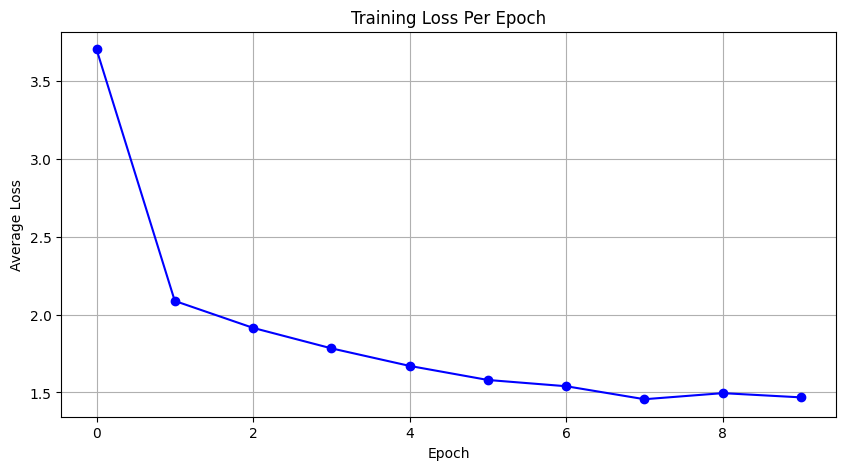

In [21]:
import torch

def train(data, epochs=10, batch_size=16, device='cpu'):
    student_model.to(device)
    teacher_model.to(device)
    
    student_model.train()
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=0.001)
    epoch_losses = []


    for epoch in range(epochs):
        total_loss = 0
        num_batches = len(data) // batch_size 
        
        for i in range(num_batches):
            batch_loss = 0
            for j in range(batch_size):
                index = i * batch_size + j
                teacher_prompt = create_extended_prompt(data[index]['context'], data[index]['query'])
                student_prompt = student_create_prompt(data[index]['query']['premise'], data[index]['query']['hypothesis'])
                
                teacher_inputs = tokenizer(teacher_prompt, return_tensors="pt").to(device)
                student_inputs = tokenizer(student_prompt, return_tensors="pt").to(device)
                
                teacher_outputs = teacher_model.generate(**teacher_inputs, max_length=teacher_inputs['input_ids'].shape[-1] + 1, output_scores=True, return_dict_in_generate=True)
                teacher_probs = torch.nn.functional.softmax(teacher_outputs.scores[0], dim=-1)
                
                student_logits = student_model(**student_inputs).logits
                student_probs = torch.nn.functional.softmax(student_logits[:, -1, :], dim=-1)
                
                kl_divergence = torch.nn.functional.kl_div(student_probs.log(), teacher_probs, reduction='batchmean')
                
                optimizer.zero_grad()
                kl_divergence.backward()
                optimizer.step()

                batch_loss += kl_divergence.item()

            # Average loss for the batch
            batch_loss /= batch_size
            total_loss += batch_loss
            # print(f"Epoch {epoch + 1}, Batch {i + 1}, Average Loss: {batch_loss}")


        # Average loss for the epoch
        epoch_loss = total_loss / num_batches
        epoch_losses.append(epoch_loss)

        print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss}")
        
    print(f"Total loss : {total_loss/epochs}")
    plot_losses(epoch_losses)


train(batches, device=device)
